# Libraries

In [1]:
import matplotlib as mpl
from matplotlib import colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from osgeo import gdal
from osgeo import osr
# import pandas as pd
# import rasterio as rio
import rioxarray as rxr
from scipy.ndimage.filters import generic_filter
from scipy.stats import mode
# import seaborn as sns
# from time import time
from tqdm import tqdm
# from tqdm.notebook import tqdm as tqdm
from yellowbrick.cluster import KElbowVisualizer

from sklearn import cluster
# from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score, rand_score, adjusted_rand_score
from sklearn.metrics import mutual_info_score, adjusted_mutual_info_score, calinski_harabasz_score, davies_bouldin_score
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
# from sklearn.preprocessing import StandardScaler

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l1

C:\Users\efar0517\AppData\Local\Temp\ipykernel_17228\1966928331.py:13: DeprecationWarning: Please use `generic_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import generic_filter


# Loading the datasets

In [2]:
# load the data
data_raster = rxr.open_rasterio('./Wilcannia_UL_Landsat8.tif').squeeze()

min_x = float(data_raster.coords['x'].min())
max_x = float(data_raster.coords['x'].max())
min_y = float(data_raster.coords['y'].min())
max_y = float(data_raster.coords['y'].max())

extent = [min_x, max_x, min_y, max_y]

# read the data
data_array = np.array(data_raster)

# reshape the input data from brc to rcb
data_xyb = np.empty((data_raster.shape[1], data_raster.shape[2], data_raster.shape[0]))
# loop through the bands to fill the empty array
for band in range(data_xyb.shape[2]):
    data_xyb[:, :, band] = data_array[band, :, :]

data_reshaped = data_xyb.reshape(data_xyb.shape[0]*data_xyb.shape[1], -1)
# scale the data
data_reshaped = minmax_scale(data_reshaped, feature_range=(0, 1), axis=0, copy=False)

# Principal components analysis

In [3]:
# pca
pca = PCA()
components = pca.fit_transform(data_reshaped)
# eigenvectors = pca.components_
# eigenvalues = pca.explained_variance_
var_ratio = pca.explained_variance_ratio_

var_sum = 0
for i in range(len(var_ratio)):
    if var_sum >= 0.9:
        break
    else:
        var_sum += var_ratio[i]

selected_components = components[:, :i]
print('Number of components:', selected_components.shape[1])

Number of components: 2


# Elbow method

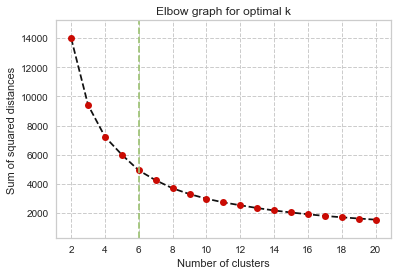

In [5]:
# elbow method
sum_squared_distance = []
range_n_clusters = range(2, 21)
for k in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=k, random_state=1)
    clusterer.fit(selected_components)
    sum_squared_distance.append(clusterer.inertia_)

range_ssd = max(sum_squared_distance) - min(sum_squared_distance)

plt.plot(range_n_clusters, sum_squared_distance, 'ko--', mfc='r')
plt.vlines(x=6, ymin=min(sum_squared_distance)-(0.1*range_ssd),
           ymax=max(sum_squared_distance)+(0.1*range_ssd), color='g', linestyles='dashed')
plt.xticks(range(2, 21, 2))
plt.ylim(min(sum_squared_distance)-(0.1*range_ssd), max(sum_squared_distance)+(0.1*range_ssd))
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow graph for optimal k')
plt.grid(linestyle='--')
plt.savefig('./Figures/pca_kmeans_landsat8_elbow.png', dpi=300)
plt.show()

# visualizer = KElbowVisualizer(cluster.KMeans(random_state=1), k=(2, 21), timings=True)
# # fit the data
# visualizer.fit(selected_components)
# # finalize and render figure
# visualizer.show()

# Silhouette score

In [ ]:
# n_clusters = 6

# fig = plt.figure(figsize=[15, 6])
# ax1 = fig.add_subplot(1, 2, 1)
# ax1.set_xlim([-0.1, 1])
# ax1.set_ylim([0, len(selected_components) + (n_clusters + 1) * 10])

# clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
# cluster_labels = clusterer.fit_predict(selected_components)

# silhouette_avg = silhouette_score(selected_components, cluster_labels)
# sample_silhouette_values = silhouette_samples(selected_components, cluster_labels)

# y_lower = 10
# for i in range(n_clusters):
#     ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
#     ith_cluster_silhouette_values.sort()
#     size_cluster_i = ith_cluster_silhouette_values.shape[0]
#     y_upper = y_lower + size_cluster_i
#     color = cm.nipy_spectral(float(i) / n_clusters)
#     ax1.fill_betweenx(
#         np.arange(y_lower, y_upper),
#         0,
#         ith_cluster_silhouette_values,
#         facecolor=color,
#         edgecolor=color,
#         alpha=0.7,
#     )
#     ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
#     y_lower = y_upper + 10

# ax1.set_title('The silhouette plot for the various clusters.')
# ax1.set_xlabel('The silhouette coefficient values')
# ax1.set_ylabel('Cluster label')

# ax1.axvline(x=silhouette_avg, color='red', linestyle='--')
# ax1.set_yticks([])
# ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# ax2 = fig.add_subplot(1, 2, 2, projection='3d')
# colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
# ax2.scatter(
#     selected_components[:, 0], selected_components[:, 1], selected_components[:, 2],
#     marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k'
# )
# ax2.set_title('The visualization of the clustered data.')
# ax2.set_xlabel('Feature space for the 1st feature')
# ax2.set_ylabel('2nd feature')
# ax2.set_zlabel('3rd feature')

# plt.suptitle(
#     'Silhouette analysis for K-means clustering on sample data with n_clusters = %d'
#     % n_clusters,
#     fontsize=14,
#     fontweight='bold',
# )

# fig.subplots_adjust(wspace=0, hspace=0)
# plt.show()

# k-means

Calinski-Harabasz score: 725156.4923
Davies-Bouldin score: 0.8481


C:\Users\efar0517\AppData\Local\Temp\ipykernel_17228\1610544417.py:23: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  invalues_mode = mode(invalues, axis=None, nan_policy='omit')


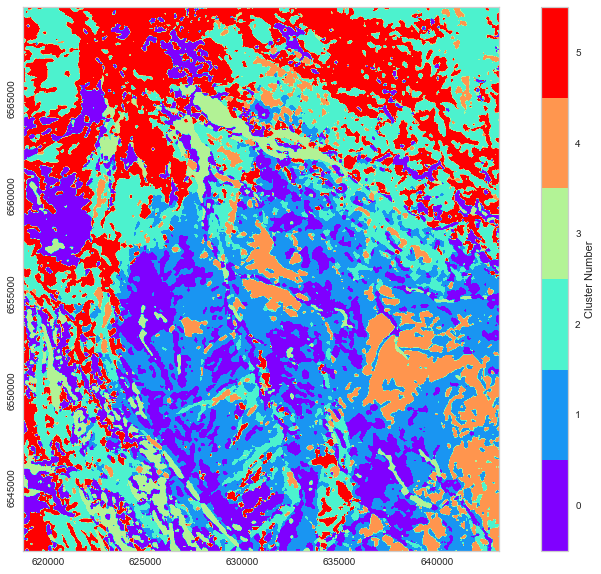

In [6]:
# k-means
n_clusters = 6

# create an object of the classifier
clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
# train
pred = clusterer.fit_predict(selected_components) # Train
# get cluster labels
labels = clusterer.labels_

# Calinski-Harabasz score
ch_score = calinski_harabasz_score(selected_components, labels)
# Davies-Bouldin score
# The minimum score is zero, and the lower values the better clustering performance
db_score = davies_bouldin_score(selected_components, labels)
print('Calinski-Harabasz score:', round(ch_score, 4))
print('Davies-Bouldin score:', round(db_score, 4))

# reshape the labels to a 3D array (single band)
labels = labels.reshape(data_array[0, :, :].shape)

def filter_function(invalues):
    invalues_mode = mode(invalues, axis=None, nan_policy='omit')
    return invalues_mode[0]

labels_major = generic_filter(labels, function=filter_function, size=7)

def plot_map(array, extent, n_clusters):
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.f'))
    plt.yticks(rotation=90, va='center')
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.f'))
    cmap = cm.get_cmap('rainbow', n_clusters)
    plt.imshow(array, cmap=cmap, extent=extent)
    cbar = plt.colorbar(label='Cluster Number')
    tick_locs = (np.arange(n_clusters) + 0.5)*(n_clusters-1)/n_clusters
    cbar.set_ticks(tick_locs)
    cbar.set_ticklabels(np.arange(n_clusters))
    plt.grid(False)

plot_map(labels_major, extent, n_clusters)

In [7]:
# export the map to a GeoTIFF file
dist_x = 30
dist_y = 30
geotransform = (min_x, dist_x, 0, max_y, 0, -dist_y)
map_file = './GIS/pca_kmeans_landsat8.tiff'

driver = gdal.GetDriverByName('GTiff')
nx = labels_major.shape[1]
ny = labels_major.shape[0]
dataset = driver.Create(map_file, nx, ny, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromEPSG(32754)
dataset.SetProjection(srs.ExportToWkt())

dataset.GetRasterBand(1).WriteArray(labels_major)
dataset.FlushCache()
dataset = None

# Canonical autoencoder

Epoch 1/10
11911/11911 [==============================] - 11s 914us/step - loss: 0.0014 - accuracy: 0.7221
Epoch 2/10
11911/11911 [==============================] - 10s 870us/step - loss: 7.0890e-04 - accuracy: 0.7370
Epoch 3/10
11911/11911 [==============================] - 10s 864us/step - loss: 6.8435e-04 - accuracy: 0.7370
Epoch 4/10
11911/11911 [==============================] - 10s 876us/step - loss: 6.7444e-04 - accuracy: 0.7370
Epoch 5/10
11911/11911 [==============================] - 10s 875us/step - loss: 6.6908e-04 - accuracy: 0.7368
Epoch 6/10
11911/11911 [==============================] - 11s 882us/step - loss: 6.6507e-04 - accuracy: 0.7367
Epoch 7/10
11911/11911 [==============================] - 10s 877us/step - loss: 6.6211e-04 - accuracy: 0.7367
Epoch 8/10
11911/11911 [==============================] - 10s 878us/step - loss: 6.5978e-04 - accuracy: 0.7367
Epoch 9/10
11911/11911 [==============================] - 11s 884us/step - loss: 6.5776e-04 - accuracy: 0.7366
Epoch

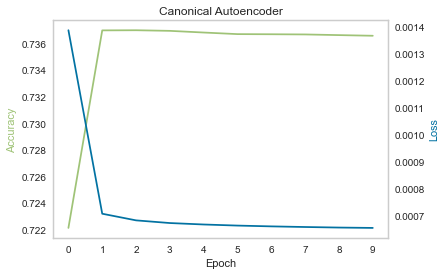

In [10]:
# autoencoder
learning_rate = 1e-4
epochs = 10

# num of predictor variables
input_dim = data_reshaped.shape[1]
input_layer = Input(shape=(input_dim, ), name='input')

# input layer
encoder_1 = Dense(6, activation='selu', activity_regularizer=l1(learning_rate))(input_layer)
# first encoder
encoder_2 = Dense(4, activation='selu', activity_regularizer=l1(learning_rate))(encoder_1)
# code layer
encoder_3 = Dense(2, activation='selu', activity_regularizer=l1(learning_rate))(encoder_2)
# first decoder
decoder_1 = Dense(4, activation='selu', activity_regularizer=l1(learning_rate))(encoder_3)
# second decoder
decoder_2 = Dense(6, activation='selu', activity_regularizer=l1(learning_rate))(decoder_1)
# output layer
decoder_3 = Dense(input_dim, activation='sigmoid', activity_regularizer=l1(learning_rate))(decoder_2)

autoencoder = Model(inputs=input_layer, outputs=decoder_3)
autoencoder.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
history = autoencoder.fit(data_reshaped, data_reshaped, epochs=epochs, batch_size=64)

encoder = Model(inputs=input_layer, outputs=encoder_3)
data_ae = encoder.predict(data_reshaped)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(history.history['accuracy'], 'g-')
ax2.plot(history.history['loss'], 'b-')
ax1.set_title('Canonical Autoencoder')
ax1.set_ylabel('Accuracy', color='g')
ax2.set_ylabel('Loss', color='b')
ax1.set_xlabel('Epoch')
ax1.set_xticks(list(range(epochs)))
ax1.grid(False)
ax2.grid(False)
plt.show()

# Elbow method

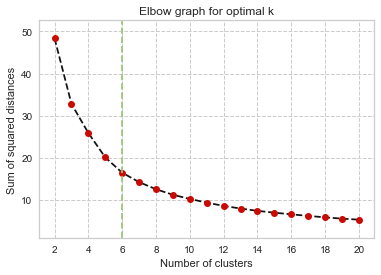

In [12]:
# elbow method
sum_squared_distance = []
range_n_clusters = range(2, 21)
for k in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=k, random_state=1)
    clusterer.fit(data_ae)
    sum_squared_distance.append(clusterer.inertia_)

range_ssd = max(sum_squared_distance) - min(sum_squared_distance)

plt.plot(range_n_clusters, sum_squared_distance, 'ko--', mfc='r')
plt.vlines(x=6, ymin=min(sum_squared_distance)-(0.1*range_ssd),
           ymax=max(sum_squared_distance)+(0.1*range_ssd), color='g', linestyles='dashed')
plt.xticks(range(2, 21, 2))
plt.ylim(min(sum_squared_distance)-(0.1*range_ssd), max(sum_squared_distance)+(0.1*range_ssd))
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow graph for optimal k')
plt.grid(linestyle='--')
plt.savefig('./Figures/ae_kmeans_landsat8_elbow.png', dpi=300)
plt.show()

# visualizer = KElbowVisualizer(cluster.KMeans(random_state=1), k=(2, 21), timings=True)
# # fit the data
# visualizer.fit(data_ae)
# # finalize and render figure
# visualizer.show()

# k-means

Calinski-Harabasz score: 712419.0317
Davies-Bouldin score: 0.8029


C:\Users\efar0517\AppData\Local\Temp\ipykernel_17228\1610544417.py:23: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  invalues_mode = mode(invalues, axis=None, nan_policy='omit')


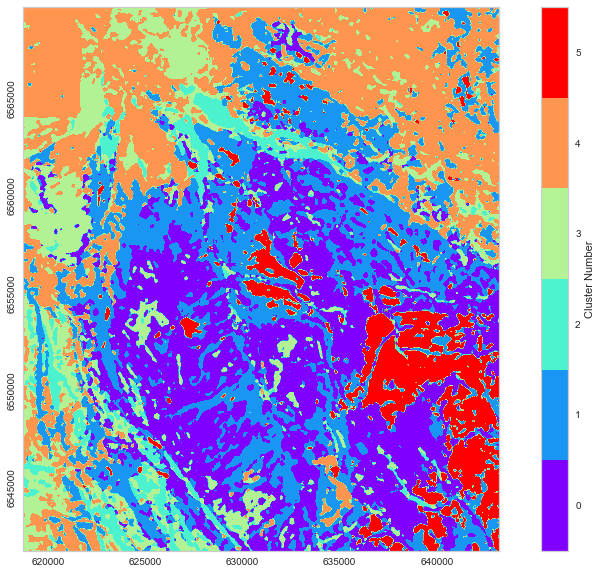

In [13]:
# k-means
n_clusters = 6

# create an object of the classifier
clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
# train
pred = clusterer.fit_predict(data_ae)
# get cluster labels
labels = clusterer.labels_

# Calinski-Harabasz score
ch_score = calinski_harabasz_score(data_ae, labels)
# Davies-Bouldin score
# The minimum score is zero, and the lower values the better clustering performance
db_score = davies_bouldin_score(data_ae, labels)
print('Calinski-Harabasz score:', round(ch_score, 4))
print('Davies-Bouldin score:', round(db_score, 4))

# reshape the labels to a 3D array (single band)
labels = labels.reshape(data_array[0, :, :].shape)
labels_major = generic_filter(labels, function=filter_function, size=7)
plot_map(labels_major, extent, n_clusters)

In [14]:
# export the map to a GeoTIFF file
dist_x = 30
dist_y = 30
geotransform = (min_x, dist_x, 0, max_y, 0, -dist_y)
map_file = './GIS/ae_kmeans_landsat8.tiff'

driver = gdal.GetDriverByName('GTiff')
nx = labels_major.shape[1]
ny = labels_major.shape[0]
dataset = driver.Create(map_file, nx, ny, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromEPSG(32754)
dataset.SetProjection(srs.ExportToWkt())

dataset.GetRasterBand(1).WriteArray(labels_major)
dataset.FlushCache()
dataset = None

# Stacked autoencoder

In [15]:
# stacked autoencoder
def model_1(input_layer, input_dim):
    # input layer
    encoder_1 = Dense(6, activation='selu', activity_regularizer=l1(learning_rate))(input_layer)
    # first encoder
    encoder_2 = Dense(4, activation='selu', activity_regularizer=l1(learning_rate))(encoder_1)
    # code layer
    encoder_3 = Dense(2, activation='selu', activity_regularizer=l1(learning_rate))(encoder_2)
    # first decoder
    decoder_1 = Dense(4, activation='selu', activity_regularizer=l1(learning_rate))(encoder_3)
    # second decoder
    decoder_2 = Dense(6, activation='selu', activity_regularizer=l1(learning_rate))(decoder_1)
    # output layer
    decoder_3 = Dense(input_dim, activation='sigmoid', activity_regularizer=l1(learning_rate))(decoder_2)
    
    return Model(inputs=input_layer, outputs=decoder_3)
    
# num of predictor variables
input_dim_1 = data_reshaped.shape[1]
input_layer_1 = Input(shape=(input_dim_1, ), name='input')

autoencoder_1 = model_1(input_layer_1, input_dim_1)
autoencoder_1.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
stack_1 = autoencoder_1.fit(data_reshaped, data_reshaped, epochs=10, batch_size=64)

autoencoder_2_input = autoencoder_1.predict(data_reshaped)
autoencoder_2_input = np.concatenate((autoencoder_2_input , data_reshaped), axis=1)

def model_2(input_layer, input_dim):
    # input layer
    encoder_1 = Dense(10, activation='selu', activity_regularizer=l1(learning_rate))(input_layer)
    # first encoder
    encoder_2 = Dense(5, activation='selu', activity_regularizer=l1(learning_rate))(encoder_1)
    # code layer
    encoder_3 = Dense(2, activation='selu', activity_regularizer=l1(learning_rate))(encoder_2)
    # first decoder
    decoder_1 = Dense(5, activation='selu', activity_regularizer=l1(learning_rate))(encoder_3)
    # second decoder
    decoder_2 = Dense(10, activation='selu', activity_regularizer=l1(learning_rate))(decoder_1)
    # output layer
    decoder_3 = Dense(input_dim, activation='sigmoid', activity_regularizer=l1(learning_rate))(decoder_2)
    
    return Model(inputs=input_layer, outputs=decoder_3), Model(inputs=input_layer, outputs=encoder_2)
                 
input_dim_2 = autoencoder_2_input.shape[1]
input_layer_2 = Input(shape=(input_dim_2, ), name='input')

autoencoder_2, encoder_2 = model_2(input_layer_2, input_dim_2)
autoencoder_2.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
stack_2 = autoencoder_2.fit(autoencoder_2_input, autoencoder_2_input, epochs=5, batch_size=32)

autoencoder_3_input = encoder_2.predict(autoencoder_2_input)
autoencoder_3_input = np.concatenate((autoencoder_3_input, autoencoder_2_input), axis=1)

def model_3(input_layer, input_dim):
    # input layer
    encoder_1 = Dense(15, activation='selu', activity_regularizer=l1(learning_rate))(input_layer)
    # first encoder
    encoder_2 = Dense(10, activation='selu', activity_regularizer=l1(learning_rate))(encoder_1)
    # second encoder
    encoder_3 = Dense(5, activation='selu', activity_regularizer=l1(learning_rate))(encoder_2)
    # third encoder
    encoder_4 = Dense(2, activation='selu', activity_regularizer=l1(learning_rate))(encoder_3)
    # first decoder
    decoder_1 = Dense(5, activation='selu', activity_regularizer=l1(learning_rate))(encoder_4)
    # second decoder
    decoder_2 = Dense(10, activation='selu', activity_regularizer=l1(learning_rate))(decoder_1)
    # third decoder
    decoder_3 = Dense(15, activation='selu', activity_regularizer=l1(learning_rate))(decoder_2)
    # output layer
    decoder_4 = Dense(input_dim, activation='sigmoid', activity_regularizer=l1(learning_rate))(decoder_3)    
    
    return Model(inputs=input_layer, outputs=decoder_4), Model(inputs=input_layer, outputs=encoder_4)

input_dim_3 = autoencoder_3_input.shape[1]
input_layer_3 = Input(shape=(input_dim_3, ), name='input')

autoencoder_3, encoder_3 = model_3(input_layer_3, input_dim_3)
autoencoder_3.compile(metrics=['accuracy'], loss='mean_squared_error', optimizer='adam')
stack_3 = autoencoder_3.fit(autoencoder_3_input, autoencoder_3_input, epochs=5, batch_size=16)

data_sae = encoder_3.predict(autoencoder_3_input)

Epoch 1/10
11911/11911 [==============================] - 11s 874us/step - loss: 0.0012 - accuracy: 0.7281
Epoch 2/10
11911/11911 [==============================] - 10s 866us/step - loss: 6.9075e-04 - accuracy: 0.7424
Epoch 3/10
11911/11911 [==============================] - 10s 874us/step - loss: 6.7310e-04 - accuracy: 0.7457
Epoch 4/10
11911/11911 [==============================] - 10s 857us/step - loss: 6.6615e-04 - accuracy: 0.7458
Epoch 5/10
11911/11911 [==============================] - 10s 874us/step - loss: 6.6223e-04 - accuracy: 0.7461
Epoch 6/10
11911/11911 [==============================] - 11s 924us/step - loss: 6.5953e-04 - accuracy: 0.7466
Epoch 7/10
11911/11911 [==============================] - 11s 902us/step - loss: 6.5797e-04 - accuracy: 0.7464
Epoch 8/10
11911/11911 [==============================] - 10s 871us/step - loss: 6.5632e-04 - accuracy: 0.7460
Epoch 9/10
11911/11911 [==============================] - 10s 871us/step - loss: 6.5540e-04 - accuracy: 0.7460
Epoch

# Elbow method

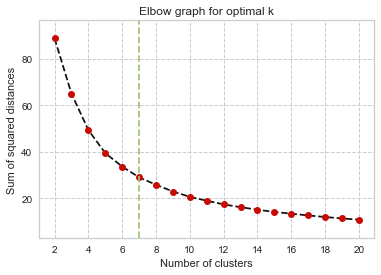

In [17]:
# elbow method
sum_squared_distance = []
range_n_clusters = range(2, 21)
for k in range_n_clusters:
    clusterer = cluster.KMeans(n_clusters=k, random_state=1)
    clusterer.fit(data_sae)
    sum_squared_distance.append(clusterer.inertia_)

range_ssd = max(sum_squared_distance) - min(sum_squared_distance)

plt.plot(range_n_clusters, sum_squared_distance, 'ko--', mfc='r')
plt.vlines(x=7, ymin=min(sum_squared_distance)-(0.1*range_ssd),
           ymax=max(sum_squared_distance)+(0.1*range_ssd), color='g', linestyles='dashed')
plt.xticks(range(2, 21, 2))
plt.ylim(min(sum_squared_distance)-(0.1*range_ssd), max(sum_squared_distance)+(0.1*range_ssd))
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow graph for optimal k')
plt.grid(linestyle='--')
plt.savefig('./Figures/sae_kmeans_landsat8_elbow.png', dpi=300)
plt.show()

# visualizer = KElbowVisualizer(cluster.KMeans(random_state=1), k=(2, 21), timings=True)
# # fit the data
# visualizer.fit(data_sae)
# # finalize and render figure
# visualizer.show()

# k-means

Calinski-Harabasz score: 560855.8011
Davies-Bouldin score: 0.8261


C:\Users\efar0517\AppData\Local\Temp\ipykernel_17228\1610544417.py:23: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  invalues_mode = mode(invalues, axis=None, nan_policy='omit')


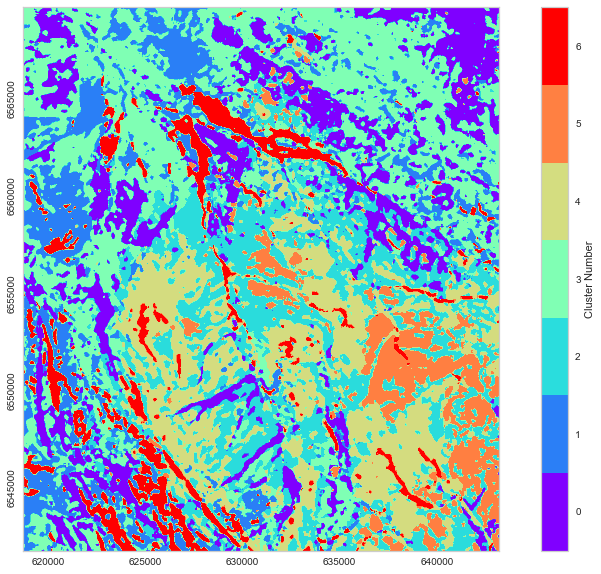

In [18]:
# k-means
n_clusters = 7

# create an object of the classifier
clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=1)
# train
pred = clusterer.fit_predict(data_sae)
# get cluster labels
labels = clusterer.labels_

# Calinski-Harabasz score
ch_score = calinski_harabasz_score(data_sae, labels)
# Davies-Bouldin score
# The minimum score is zero, and the lower values the better clustering performance
db_score = davies_bouldin_score(data_sae, labels)
print('Calinski-Harabasz score:', round(ch_score, 4))
print('Davies-Bouldin score:', round(db_score, 4))

# reshape the labels to a 3D array (single band)
labels = labels.reshape(data_array[0, :, :].shape)
labels_major = generic_filter(labels, function=filter_function, size=7)
plot_map(labels_major, extent, n_clusters)

In [19]:
# export the map to a GeoTIFF file
dist_x = 30
dist_y = 30
geotransform = (min_x, dist_x, 0, max_y, 0, -dist_y)
map_file = './GIS/sae_kmeans_landsat8.tiff'

driver = gdal.GetDriverByName('GTiff')
nx = labels_major.shape[1]
ny = labels_major.shape[0]
dataset = driver.Create(map_file, nx, ny, 1, gdal.GDT_Float32)
dataset.SetGeoTransform(geotransform)
srs = osr.SpatialReference()
srs.ImportFromEPSG(32754)
dataset.SetProjection(srs.ExportToWkt())

dataset.GetRasterBand(1).WriteArray(labels_major)
dataset.FlushCache()
dataset = None